In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [35]:
import numpy as np
from scipy.ndimage import gaussian_filter
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, LayerNormalization

from sklearn.model_selection import train_test_split
from skimage.feature import local_binary_pattern
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from collections import Counter

from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
# Use pathlib to define file paths
base_dir = Path("d:/GitHub/IFT6390BKaggle2")  # Set your project base directory
train_file_path = base_dir / "Data" / "train_data.pkl"
test_file_path = base_dir / "Data" / "test_data.pkl"

In [4]:
# Load the pickle file
with open(train_file_path, 'rb') as f:
    train_data = pickle.load(f)


X_data = np.array(train_data['images'])  # Convert to NumPy array
y_data = np.array(train_data['labels'])  # Convert to NumPy array

with open(test_file_path, 'rb') as g:
    test_data = pickle.load(g)

# Access images and labels
X_test_data = np.array(test_data['images'])  # Convert to NumPy array


In [5]:
# Print basic information
print("Shape of images:", X_data.shape)  # Expected: (N, 28, 28)
print("Number of labels:", len(y_data))  # Expected: N
print("Unique labels:", np.unique(y_data))

print(X_test_data.shape)


Shape of images: (97477, 28, 28)
Number of labels: 97477
Unique labels: [0 1 2 3]
(1000, 28, 28)


# Visualizations

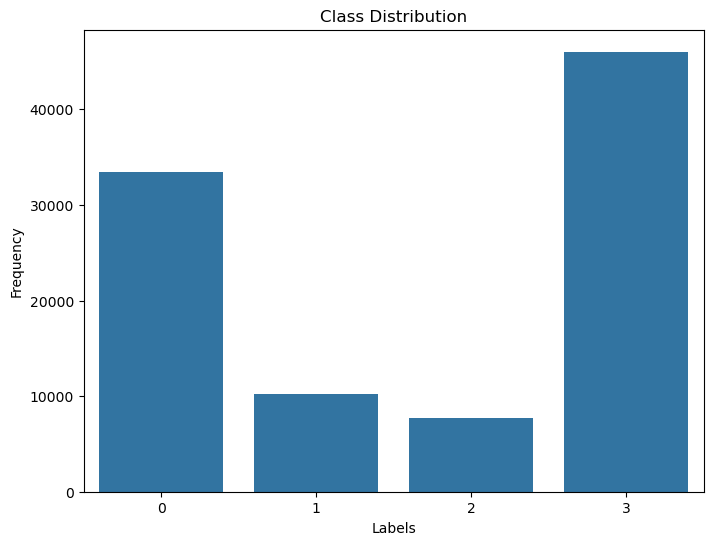

In [6]:
def plot_class_distribution(labels):
    """
    Plot the distribution of labels.
    """
    plt.figure(figsize=(8, 6))
    sns.countplot(x=labels)
    plt.title("Class Distribution")
    plt.xlabel("Labels")
    plt.ylabel("Frequency")
    plt.show()

# Plot class distribution
plot_class_distribution(y_data)

In [7]:
def unflatten_images(flattened_images, original_shape):
    """
    Reshape flattened images back to their original shape.

    Parameters:
        flattened_images (ndarray): Flattened image data (num_samples x num_features).
        original_shape (tuple): Original image shape (e.g., height, width, channels).

    Returns:
        ndarray: Reshaped images (num_samples x original_shape).
    """
    return flattened_images.reshape((-1, *original_shape))

In [8]:
# === Step 1: Undersample X_train === #
def undersample_data(X, y):
    unique_classes, class_counts = np.unique(y, return_counts=True)
    print(f"Class counts before undersampling: {dict(zip(unique_classes, class_counts))}")
    
    min_class_size = np.min(class_counts)
    X_undersampled = []
    y_undersampled = []

    for cls in unique_classes:
        class_indices = np.where(y == cls)[0]
        undersampled_indices = np.random.choice(class_indices, size=min_class_size, replace=False)
        X_undersampled.append(X[undersampled_indices])
        y_undersampled.append(y[undersampled_indices])

    X_undersampled = np.vstack(X_undersampled)
    y_undersampled = np.concatenate(y_undersampled)

    shuffled_indices = np.random.permutation(len(y_undersampled))
    X_undersampled = X_undersampled[shuffled_indices]
    y_undersampled = y_undersampled[shuffled_indices]

    print(f"Class counts after undersampling: {dict(zip(*np.unique(y_undersampled, return_counts=True)))}")
    return X_undersampled, y_undersampled

# Convolutional Neural Network

In [9]:
def focal_loss(alpha=0.25, gamma=2.0):
    """
    Focal Loss for multi-class classification.
    
    Args:
        alpha (float): Weighting factor for class imbalance.
        gamma (float): Focusing parameter to down-weight easy examples.
        
    Returns:
        loss_fn: A callable loss function.
    """
    def loss_fn(y_true, y_pred):
        # Clip predictions to avoid numerical instability
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        
        # Compute cross-entropy loss
        ce_loss = -y_true * tf.math.log(y_pred)
        
        # Apply the weighting factor and focusing parameter
        weight = alpha * tf.pow(1 - y_pred, gamma)
        focal_loss = tf.reduce_sum(weight * ce_loss, axis=-1)
        
        return focal_loss
    
    return loss_fn

In [10]:
# === Denoising Function === #
def denoise_images(images, sigma=1):
    denoised_images = []
    for img in images:
        denoised = gaussian_filter(img, sigma=sigma)  # Gaussian blur for denoising
        denoised_images.append(denoised)
    return np.array(denoised_images)

# === Texture Feature Extraction (LBP) === #
def extract_lbp_features(images, points, radius, method='uniform'):
    """
    Extract LBP features from a set of images.
    
    Args:
        images (numpy.ndarray): Array of grayscale images.
        points (int): Number of points in the LBP pattern.
        radius (int): Radius of the LBP pattern.
        method (str): Method for LBP extraction ('uniform', 'nri_uniform', etc.).
    
    Returns:
        numpy.ndarray: Array of LBP features for all images.
    """
    lbp_features = []
    for img in images:
        lbp = local_binary_pattern(img, points, radius, method)
        lbp_features.append(lbp)
    return np.array(lbp_features)

In [11]:
# Split data into train and test sets
X_train, X_val, y_train, y_val = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42, stratify=y_data
)

In [43]:
def preprocess_images_with_intermediate(X_train, X_val, y_train, y_val, radius=1, points=None, method='uniform'):
    """
    Preprocess images and optionally return intermediate outputs.
    """
    if points is None:
        points = 8 * radius

    X_train, y_train = undersample_data(X_train, y_train)

    # Apply denoising to training and validation sets
    X_train_denoised = denoise_images(X_train)
    X_val_denoised = denoise_images(X_val)

    # Extract LBP features
    X_train_lbp = extract_lbp_features(X_train_denoised, points, radius, method)
    X_val_lbp = extract_lbp_features(X_val_denoised, points, radius, method)

    # Normalize and reshape features
    X_train_denoised = X_train_denoised / 255.0
    X_val_denoised = X_val_denoised / 255.0
    X_train_lbp = X_train_lbp / np.max(X_train_lbp)
    X_val_lbp = X_val_lbp / np.max(X_val_lbp)

    X_train_denoised = X_train_denoised.reshape(-1, 28, 28, 1)
    X_val_denoised = X_val_denoised.reshape(-1, 28, 28, 1)
    X_train_lbp = X_train_lbp.reshape(-1, 28, 28, 1)
    X_val_lbp = X_val_lbp.reshape(-1, 28, 28, 1)

    # Combine features
    X_train_combined = np.concatenate([X_train_denoised, X_train_lbp], axis=-1)
    X_val_combined = np.concatenate([X_val_denoised, X_val_lbp], axis=-1)

    # Convert labels to categorical
    num_classes = len(np.unique(y_train))
    y_train_categorical = to_categorical(y_train, num_classes)
    y_val_categorical = to_categorical(y_val, num_classes)

    return X_train_combined, X_val_combined, y_train_categorical, y_val_categorical, num_classes, X_train_denoised, X_train_lbp


In [47]:
X_train_combined, X_val_combined, y_train_categorical, y_val_categorical, num_classes, X_train_denoised, X_train_lbp = preprocess_images_with_intermediate(
    X_train, X_val, y_train, y_val, radius=1, points=8, method='uniform'
)



Class counts before undersampling: {0: 26787, 1: 8170, 2: 6203, 3: 36821}
Class counts after undersampling: {0: 6203, 1: 6203, 2: 6203, 3: 6203}


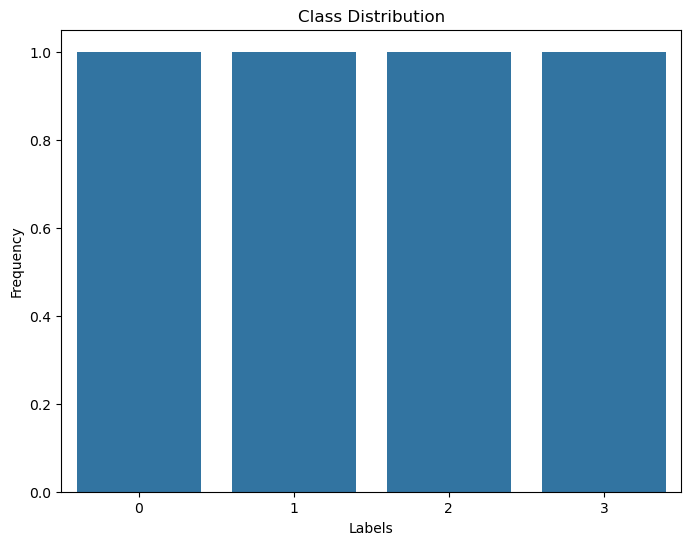

In [48]:
y_val_categorical
np.unique(np.argmax(y_val_categorical, axis=1))
plot_class_distribution(np.unique(np.argmax(y_val_categorical, axis=1)))

# Build CNN Model

Epoch 1/40
387/387 [==============================] - 22s 55ms/step - loss: 1.3702 - accuracy: 0.2912 - val_loss: 1.3407 - val_accuracy: 0.4175
Epoch 2/40
387/387 [==============================] - 21s 55ms/step - loss: 1.2614 - accuracy: 0.4130 - val_loss: 1.3035 - val_accuracy: 0.5208
Epoch 3/40
387/387 [==============================] - 21s 54ms/step - loss: 1.1794 - accuracy: 0.4628 - val_loss: 1.2574 - val_accuracy: 0.5283
Epoch 4/40
387/387 [==============================] - 21s 55ms/step - loss: 1.1347 - accuracy: 0.4875 - val_loss: 1.0548 - val_accuracy: 0.6127
Epoch 5/40
387/387 [==============================] - 21s 55ms/step - loss: 1.1139 - accuracy: 0.5002 - val_loss: 1.1044 - val_accuracy: 0.5906
Epoch 6/40
387/387 [==============================] - 21s 54ms/step - loss: 1.0847 - accuracy: 0.5155 - val_loss: 1.1212 - val_accuracy: 0.5899
Epoch 7/40
387/387 [==============================] - 22s 56ms/step - loss: 1.0727 - accuracy: 0.5242 - val_loss: 1.0476 - val_accuracy:

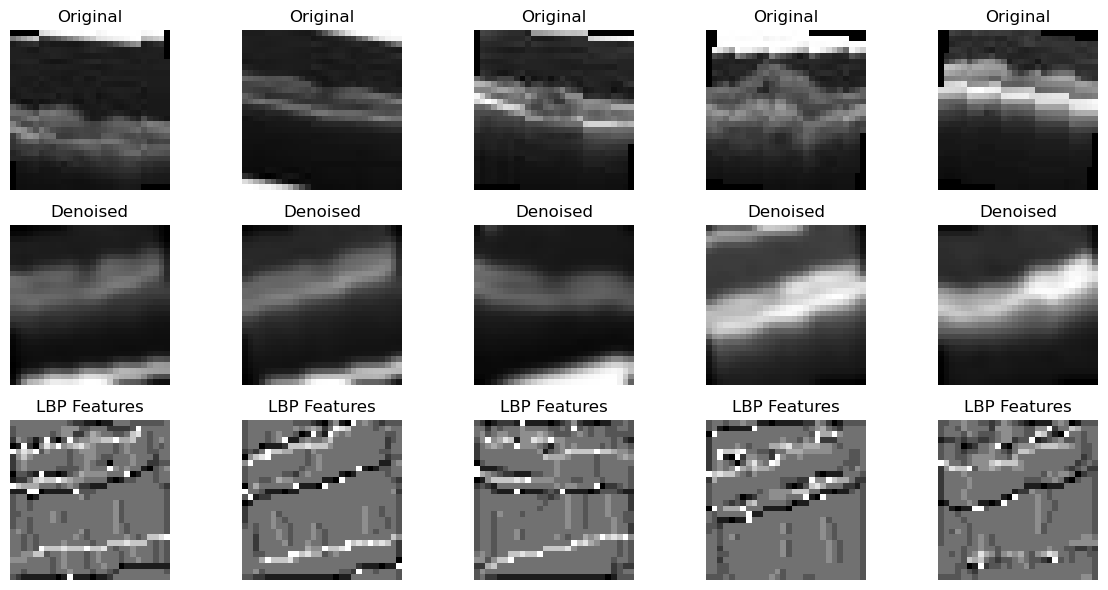

In [54]:
model = Sequential([
    Input(shape=(28, 28, 2)),  # 2 channels: original + LBP features
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Adjust for the number of classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_combined, y_train_categorical,
    validation_data=(X_val_combined, y_val_categorical),
    epochs=40,
    batch_size=64,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)

# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val_combined, y_val_categorical)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# === Visualization of Denoised Images and LBP Features === #
# Display some original, denoised, and LBP images
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(3, 5, i + 6)
    plt.imshow(X_train_denoised[i].squeeze(), cmap='gray')
    plt.title("Denoised")
    plt.axis('off')
    
    plt.subplot(3, 5, i + 11)
    plt.imshow(X_train_lbp[i].squeeze(), cmap='gray')
    plt.title("LBP Features")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

In [ ]:
# Plot Loss and Accuracy for Training and Validation Sets
plt.figure(figsize=(12, 5))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


610/610 [==============================] - 2s 4ms/step
Class Distribution of Predictions: Counter({2: 7402, 3: 7178, 0: 2891, 1: 2025})
Class Distribution of Actual Labels: Counter({3: 9205, 0: 6697, 1: 2043, 2: 1551})


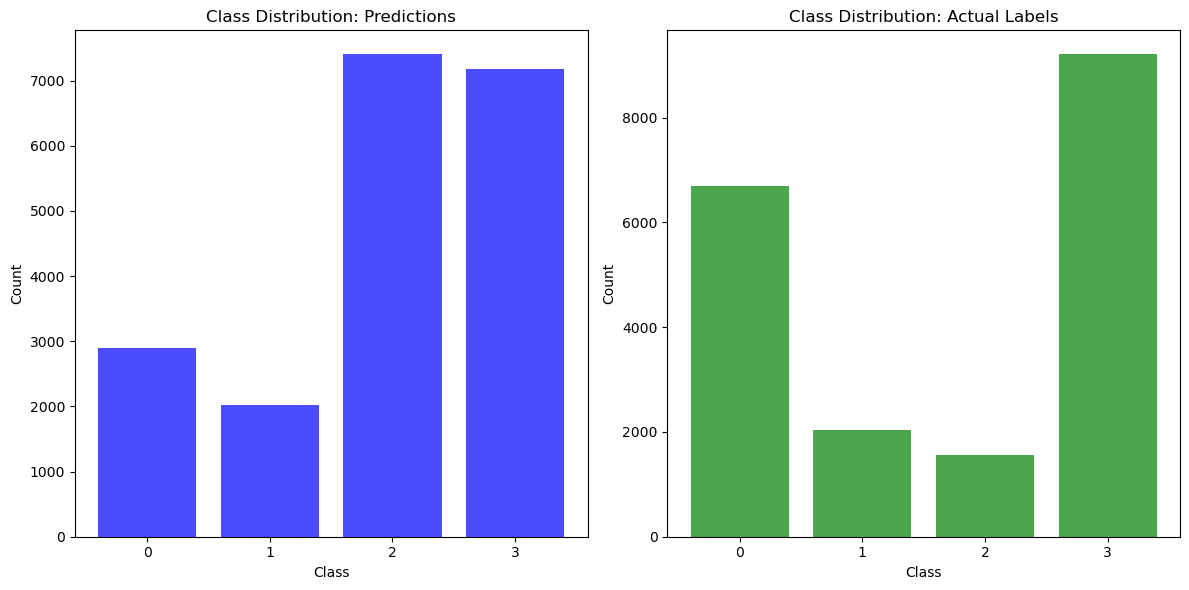

In [55]:
# Step 1: Get Model Predictions
y_pred_probs = model.predict(X_val_combined)  # Predicted probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Predicted classes
y_true_classes = np.argmax(y_val_categorical, axis=1)  # True classes

# Count the class distribution of predictions
predicted_distribution = Counter(y_pred_classes)
actual_distribution = Counter(y_true_classes)

# Print the class distributions
print("Class Distribution of Predictions:", predicted_distribution)
print("Class Distribution of Actual Labels:", actual_distribution)

# Visualize the class distributions
classes = range(len(predicted_distribution))  # Assuming 0 to num_classes-1 classes

plt.figure(figsize=(12, 6))

# Plot predicted class distribution
plt.subplot(1, 2, 1)
plt.bar(classes, [predicted_distribution.get(c, 0) for c in classes], color='blue', alpha=0.7)
plt.title("Class Distribution: Predictions")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(classes)

# Plot actual class distribution
plt.subplot(1, 2, 2)
plt.bar(classes, [actual_distribution.get(c, 0) for c in classes], color='green', alpha=0.7)
plt.title("Class Distribution: Actual Labels")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(classes)

plt.tight_layout()
plt.show()

In [18]:
print(y_pred_classes)

[3 2 3 ... 3 2 2]


# Test Prediciton

In [19]:
def preprocess_test_images(X_test, radius=1, points=None, method='uniform'):
    """
    Preprocess test images by denoising, extracting LBP features, normalizing, reshaping, and combining features.
    
    Args:
        X_test (numpy.ndarray): Test images of shape (num_samples, height, width).
        radius (int): Radius for LBP (default=1).
        points (int): Number of points for LBP (default=None, computed as 8 * radius).
        method (str): LBP method ('uniform', 'nri_uniform', etc.).
        
    Returns:
        X_test_combined (numpy.ndarray): Combined test images with original + LBP features.
    """
    if points is None:
        points = 8 * radius

    # Apply denoising to test set
    X_test_denoised = denoise_images(X_test)

    # Extract LBP features
    X_test_lbp = extract_lbp_features(X_test_denoised, points, radius, method)

    # Normalize features
    X_test_denoised = X_test_denoised / 255.0
    X_test_lbp = X_test_lbp / np.max(X_test_lbp)

    # Reshape features
    X_test_denoised = X_test_denoised.reshape(-1, 28, 28, 1)
    X_test_lbp = X_test_lbp.reshape(-1, 28, 28, 1)

    # Combine features
    X_test_combined = np.concatenate([X_test_denoised, X_test_lbp], axis=-1)

    return X_test_combined


In [20]:
# Preprocess the test dataset
X_test_combined = preprocess_test_images(X_test_data, radius=1, points=8, method='uniform')

print(f"Processed Test Dataset Shape: {X_test_combined.shape}")


Processed Test Dataset Shape: (1000, 28, 28, 2)


C:\Users\cheng\anaconda3\envs\tf_env\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


610/610 [==============================] - 1s 2ms/step


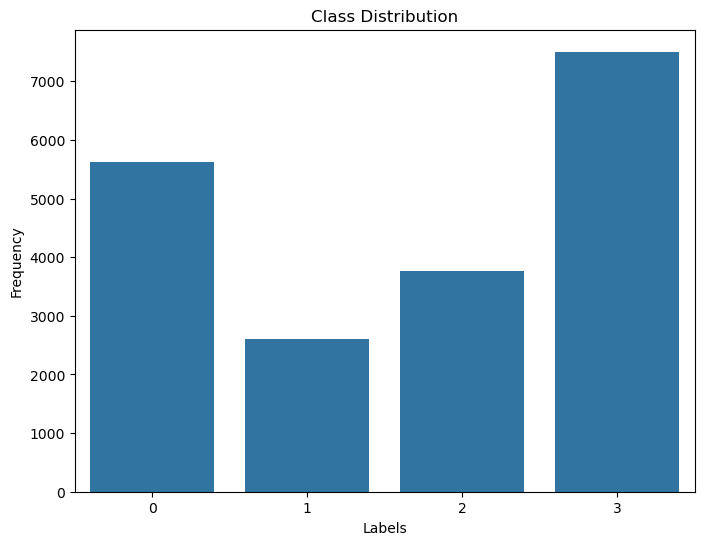

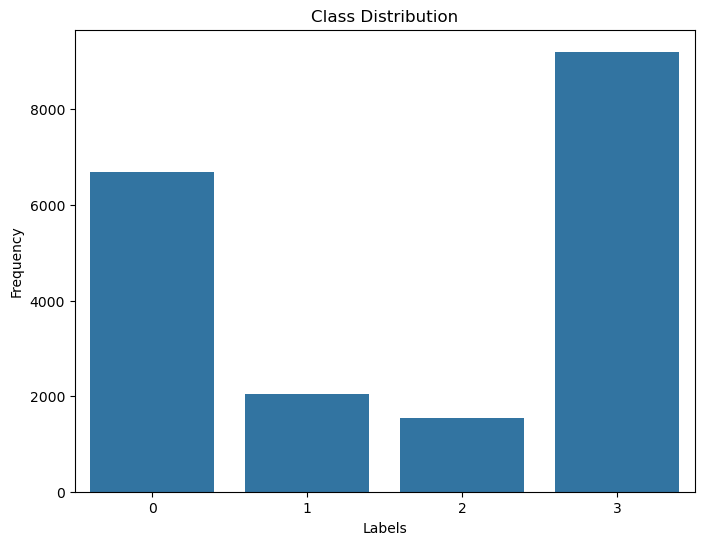

In [21]:
# Make predictions using the trained CNN model
predictions_val = model.predict(X_val_combined)

# Convert probabilities to class labels
predicted_classes_val = np.argmax(predictions_val, axis=1)

plot_class_distribution(predicted_classes_val)
plot_class_distribution(y_val)

In [22]:
# Predict using the trained model
predictions = model.predict(X_test_combined)
predicted_classes = np.argmax(predictions, axis=1)

print(f"Predicted Classes: {predicted_classes}")

32/32 [==============================] - 0s 2ms/step
Predicted Classes: [0 2 3 2 0 2 1 0 0 3 0 1 3 3 3 3 0 0 1 0 1 0 2 3 0 2 0 1 0 0 0 2 0 3 3 3 1
 0 3 1 3 1 1 0 3 1 3 1 1 0 2 1 1 0 2 1 0 1 0 1 1 3 3 2 2 1 3 0 0 3 1 1 3 2
 0 3 2 2 3 1 1 3 0 3 3 2 1 2 2 0 0 3 0 2 1 0 2 2 1 1 3 0 0 3 3 3 2 3 0 2 1
 1 0 0 3 3 0 0 3 3 0 0 2 1 0 0 1 0 3 2 1 3 1 0 2 2 1 0 0 0 1 0 1 1 1 2 3 2
 0 1 1 0 0 1 1 1 0 0 0 1 3 3 3 2 0 1 3 1 2 3 1 0 3 0 0 3 0 2 0 0 0 0 3 2 3
 3 0 0 3 2 0 2 3 2 3 0 3 0 1 0 3 0 0 1 0 0 1 1 0 0 1 0 1 3 3 0 3 2 2 3 3 2
 2 0 3 3 0 0 3 0 0 3 1 1 0 0 1 1 1 2 0 0 0 1 1 2 1 0 0 3 2 0 0 3 0 2 3 2 1
 0 3 3 1 1 1 0 3 3 0 2 0 1 2 0 0 0 2 1 1 0 2 1 2 1 3 3 0 1 3 0 2 2 0 0 2 0
 0 3 1 1 2 3 0 1 1 0 0 1 0 3 0 3 0 3 0 3 3 0 0 0 3 3 0 3 2 0 1 0 2 3 2 2 0
 0 0 0 1 0 0 1 3 0 3 0 0 0 3 0 3 3 1 1 0 3 1 0 1 1 0 0 3 2 3 2 3 2 3 0 1 1
 1 2 3 3 1 1 2 3 2 3 3 2 0 0 2 0 0 1 3 2 0 0 1 3 0 1 2 2 0 1 3 3 0 1 1 2 2
 0 3 1 1 2 0 3 1 2 2 0 0 2 3 2 1 3 3 0 0 0 0 1 0 3 0 3 2 1 3 0 0 1 1 1 1 3
 2 0 3 0 1 0 0 3 3 0 0 0 2 3

# Save Predictions

In [26]:
# Create a DataFrame for the output


def save_y_csv(y):

    submission_data = pd.DataFrame({
        "ID": np.arange(1, len(y) + 1),  # IDs start from 1
        "Class": y
    })
    # Save to CSV
    output_filename = "submission_milestone_2.4.csv"
    submission_data.to_csv(output_filename, index=False)
    
    print(f"Submission file saved as {output_filename}")


In [27]:
y = predicted_classes
save_y_csv(y)

Submission file saved as submission_milestone_2.4.csv


In [25]:
y.shape

(1000,)